In [44]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patheffects as pe
from scipy.ndimage import rotate
sys.path.append('../../DBU_Graph')
from nuscenes.nuscenes import NuScenes, NuScenesExplorer
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.prediction import PredictHelper
import json
import math
from pyquaternion import Quaternion
import numpy as np
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap
import seaborn as sns
from PIL import Image

In [2]:
FREQUENCY = 2
dt = 1 / FREQUENCY
history_sec = 2
future_sec = 6
history_frames = history_sec*FREQUENCY
future_frames = future_sec*FREQUENCY

base_path='/home/sandra/PROGRAMAS/DBU_Graph/NuScenes'
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/home/sandra/PROGRAMAS/raw_data/nuscenes'
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)  
helper = PredictHelper(nuscenes)
predictions = json.load(open('./challenge_inference.json'))

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.323 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
instance=predictions[0]['instance']
sample_token=predictions[0]['sample']
pred=predictions[0]['prediction'] #25 predictions (modes) of size T_pred=12 frames (6s 2Hz)
len(pred[0])
future=helper.get_future_for_agent(instance,sample_token, seconds=future_sec, in_agent_frame=False)
history=helper.get_past_for_agent(instance,sample_token, seconds=history_sec, in_agent_frame=False)

In [75]:
annotation = helper.get_sample_annotation(instance, sample_token)
print(annotation)
history=np.vstack([history[::-1], annotation['translation'][:2]])

{'token': '0b6df6206d084eb8a03dc5eaba5bcef9', 'sample_token': '700c1a25559b4433be532de3475e58a9', 'instance_token': 'ab8d210d019b44abae3c4e0eee6ce8ba', 'visibility_token': '4', 'attribute_tokens': ['ab83627ff28b465b85c427162dec722f'], 'translation': [635.894, 1637.231, 0.065], 'size': [0.621, 0.647, 1.778], 'rotation': [0.34134762573674937, 0.0, 0.0, 0.9399371247077563], 'prev': '19c169986ce740c8ba990fda71b52970', 'next': 'c2f6100add57418a84e516f3bd65c2c5', 'num_lidar_pts': 6, 'num_radar_pts': 1, 'category_name': 'human.pedestrian.adult'}


In [5]:
sample=nuscenes.get('sample', sample_token)
scene=nuscenes.get('scene', sample['scene_token'])
scene_name = scene['name']
log=nuscenes.get('log', scene['log_token'])
location = log['location']
map = nuscenes.get('map', log['map_token'])
map_mask=map['mask']
nusc_map = NuScenesMap(dataroot=DATAROOT, map_name=location)
print(scene_name, location)

scene-0103 boston-seaport


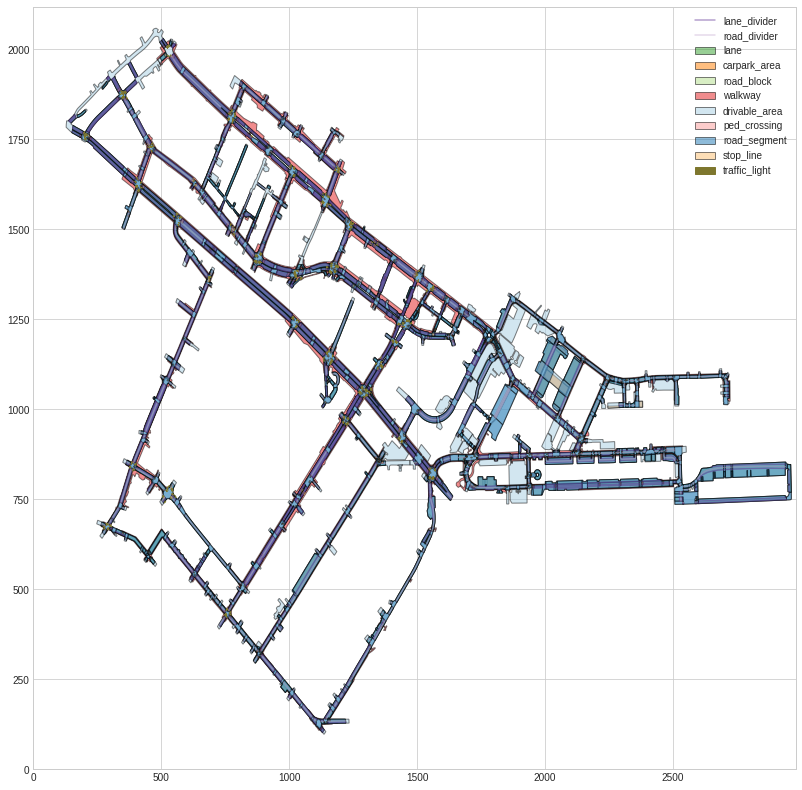

In [6]:
fig, ax = nusc_map.render_layers(nusc_map.non_geometric_layers, figsize=1)

In [50]:
print(history[::-1], '\n\n'
      , annotation['translation'], '\n\n'
     , future)

[[ 637.141 1636.252]
 [ 636.727 1636.578]
 [ 636.313 1636.905]] 

 [635.894, 1637.231, 0.065] 

 [[ 635.464 1637.566]
 [ 635.034 1637.901]
 [ 634.64  1638.235]
 [ 634.245 1638.568]
 [ 633.85  1638.901]
 [ 633.403 1639.276]
 [ 632.956 1639.65 ]
 [ 632.491 1639.947]
 [ 632.026 1640.243]
 [ 631.611 1640.546]
 [ 631.196 1640.849]
 [ 630.743 1641.102]]


100%|██████████| 1/1 [00:00<00:00, 3847.99it/s]

Adding ego poses to map...
Creating plot...


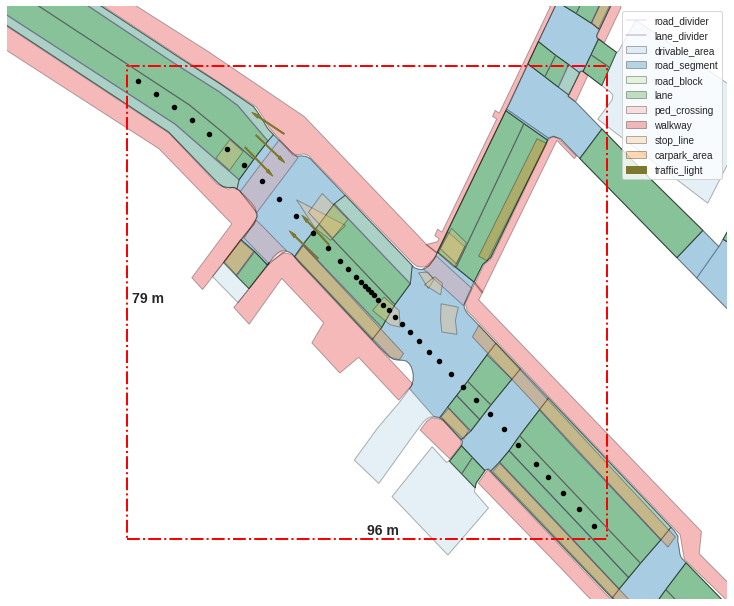

In [22]:
poses, fig, ax = nusc_map.render_egoposes_on_fancy_map(nuscenes, sample['scene_token'], alpha=0.3)

(590.1202137947669, 1563.2390413260864, 701.4516847591035, 1657.490776275174)


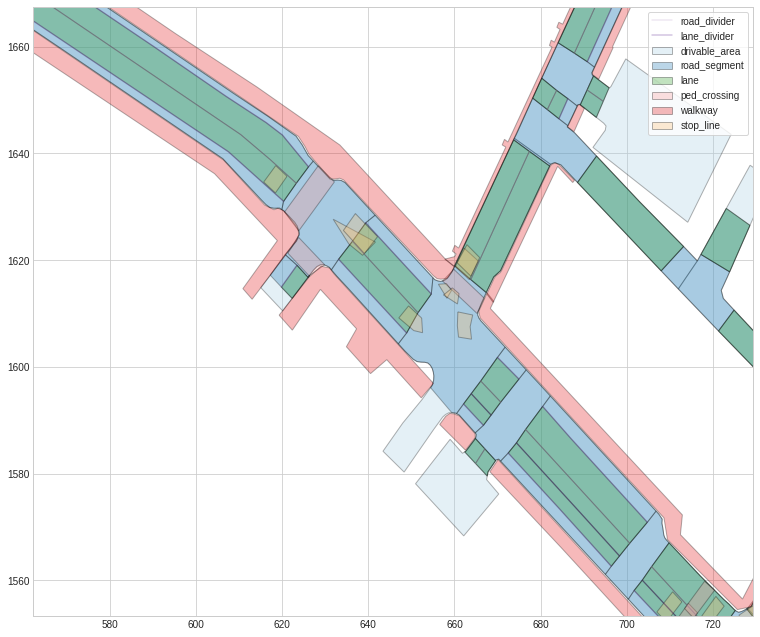

In [36]:
#Define patch using ego poses

patch = (poses[:,0].min()-10,poses[:,1].min()-10,poses[:,0].max()+10,poses[:,1].max()+10)
print(patch)
fig, ax = nusc_map.render_map_patch(patch, layers, figsize=(10, 10), alpha=0.3, render_egoposes_range=False)

In [93]:
#Ids of scenes with a bad match between localization and map.
scene_blacklist = [499, 515, 517]

patch_margin = 2
min_diff_patch = 30

#Iterate over sequences: 1 sample_token, N_agents instance_tokens
    # From sample get scene -> render map with ego_poses
    # Iterate over N agents: 
def plot_agent(predictions):
    scene_name_prev='0'
    for agent in predictions:
        instance=predictions[0]['instance']
        sample_token=predictions[0]['sample']
        annotation = helper.get_sample_annotation(instance, sample_token)
        prediction=np.array(predictions[0]['prediction']) #25 predictions (modes) of size T_pred=12 frames (6s 2Hz)
        future=helper.get_future_for_agent(instance,sample_token, seconds=future_sec, in_agent_frame=False)
        history_reversed=helper.get_past_for_agent(instance,sample_token, seconds=history_sec, in_agent_frame=False)
        history=np.vstack([history_reversed[::-1], annotation['translation'][:2]])
        
        sample=nuscenes.get('sample', sample_token)
        scene=nuscenes.get('scene', sample['scene_token'])
        scene_name = scene['name']
        
        #Render new scene
        if scene_name != scene_name_prev:
            
            if scene_name_prev != '0':
                #Save last scene
                fig.savefig('visualizations/scene_' + scene_id + '.pdf', dpi=300, bbox_inches='tight')
            
            scene_name_prev=scene_name
            scene_id = int(scene_name.replace('scene-', ''))
            log=nuscenes.get('log', scene['log_token'])
            location = log['location']
            nusc_map = NuScenesMap(dataroot=DATAROOT, map_name=location)
            scene_record = nuscenes.get('scene', scene['token'])
            
            # Print a warning if the localization is known to be bad.
            if scene_id in scene_blacklist:
                print('Warning: %s is known to have a bad fit between ego pose and map.' % scene_name)
                
            sample_tokens = nuscenes.field2token('sample', 'scene_token', scene['token'])
            ego_poses=[]
            for sample_token in sample_tokens:
                sample_record = nuscenes.get('sample', sample_token)
                
                # Poses are associated with the sample_data. Here we use the lidar sample_data.
                sample_data_record = nuscenes.get('sample_data', sample_record['data']['LIDAR_TOP'])
                pose_record = nuscenes.get('ego_pose', sample_data_record['ego_pose_token'])

                # Calculate the pose on the map and append.
                ego_poses.append(pose_record['translation'])  
                
            # Check that ego poses aren't empty.
            assert len(ego_poses) > 0, 'Error: Found 0 ego poses. Please check the inputs.'
            ego_poses = np.vstack(ego_poses)[:, :2]
            
            # Render the map patch with the current ego poses.
            min_patch = np.floor(ego_poses.min(axis=0) - patch_margin)
            max_patch = np.ceil(ego_poses.max(axis=0) + patch_margin)
            diff_patch = max_patch - min_patch
            if any(diff_patch < min_diff_patch):
                center_patch = (min_patch + max_patch) / 2
                diff_patch = np.maximum(diff_patch, min_diff_patch)
                min_patch = center_patch - diff_patch / 2
                max_patch = center_patch + diff_patch / 2
            my_patch = (min_patch[0], min_patch[1], max_patch[0], max_patch[1])
            
            fig, ax = nusc_map.render_map_patch(my_patch, nusc_map.non_geometric_layers, figsize=(10, 10), alpha=0.3,
                                        render_egoposes_range=False,
                                        render_legend=True, bitmap=None)
            
        # Plot predictions
        for t in range(prediction.shape[1]):
             sns.kdeplot(x=prediction[:,t,0], y=prediction[:,t,1],
                 ax=ax, shade=True, thresh=0.05, 
                 color='b', zorder=600, alpha=0.8)

        #Plot history
        ax.plot(history[:, 0], history[:, 1], 'k--')
        #Plot future
        ax.plot(future[:, 0],
                future[:, 1],
                'w--',
                zorder=650,
                path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
        
        # Current Node Position
        node_circle_size=0.3
        circle_edge_width=0.5
        circle = plt.Circle((history[-1, 0],
                             history[-1, 1]),
                            node_circle_size,
                            facecolor='g',
                            edgecolor='k',
                            lw=circle_edge_width,
                            zorder=3)
        ax.add_artist(circle)
    
    ax.axis('off')
    fig.savefig('qual_nuScenes_map_pos.pdf', dpi=300, bbox_inches='tight')
        
        

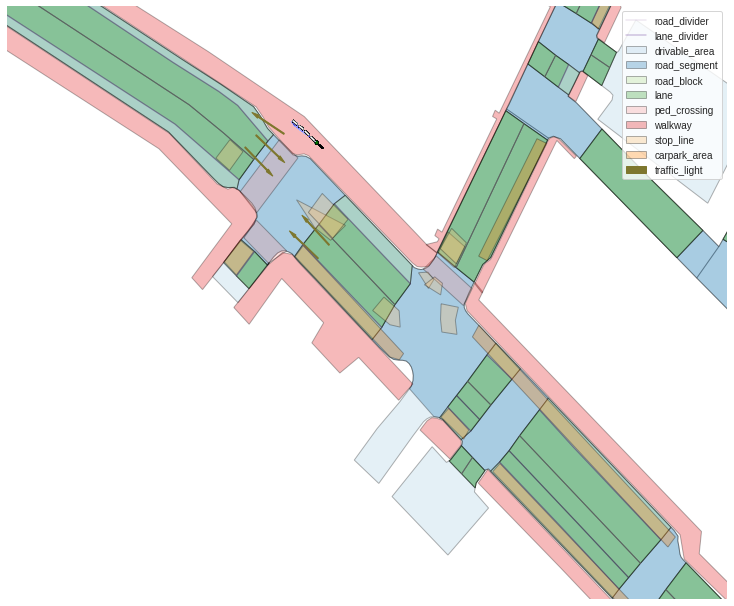

In [94]:
plot_agent(predictions)

In [77]:
ax.plot([], [], 'ko-',
        zorder=620,
        markersize=4,
        linewidth=2, alpha=0.7, label='Ours (MM)')

ax.plot([],
        [],
        'w--o', label='Ground Truth',
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

In [76]:
#pred holds 25 predictions (modes) [25,T_pred,2]
prediction = np.array(pred)
for t in range(prediction.shape[1]):
     sns.kdeplot(x=prediction[:,t,0], y=prediction[:,t,1],
                 ax=ax, shade=True, thresh=0.05, 
                 color='b', zorder=600, alpha=0.8)

#shade_lowest=False,
#Plot history
ax.plot(history[:, 0], history[:, 1], 'k--')
#Plot future
ax.plot(future[:, 0],
        future[:, 1],
        'w--',
        zorder=650,
        path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
# Current Node Position
node_circle_size=0.3
circle_edge_width=0.5
circle = plt.Circle((history[-1, 0],
                     history[-1, 1]),
                    node_circle_size,
                    facecolor='g',
                    edgecolor='k',
                    lw=circle_edge_width,
                    zorder=3)
ax.add_artist(circle)
ax.axis('off')
fig.savefig('qual_nuScenes_map_pos.pdf', dpi=300, bbox_inches='tight')

(5794, 4244, 6924, 5374)


AttributeError: 'Line2D' object has no property 'extent'

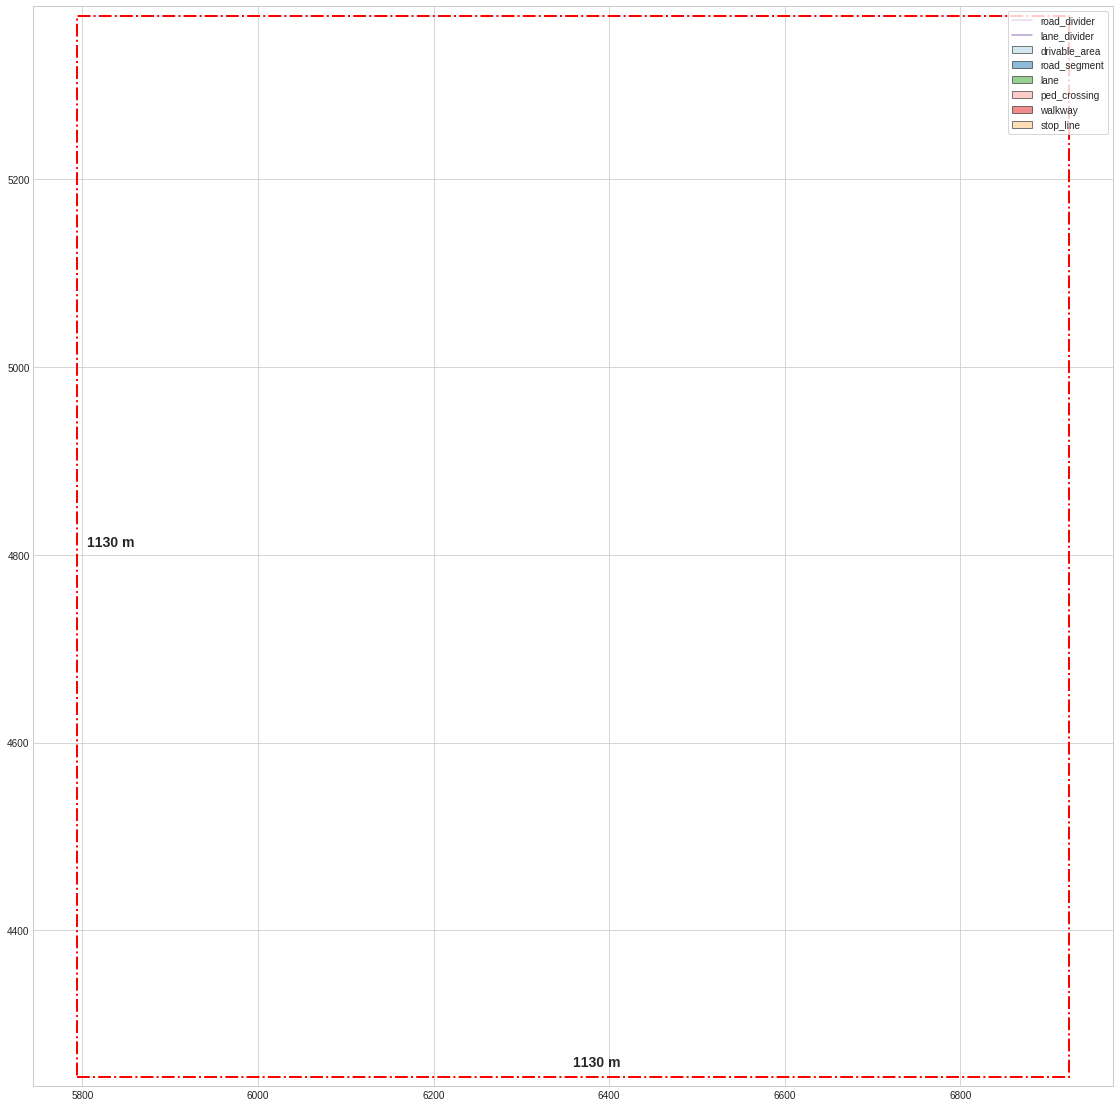

In [17]:
### From render_ego_centric_map in nuscenes.py  + Trajectron Qualitive

layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']


def crop_image(image: np.array,
               x_px: int,
               y_px: int,
               axes_limit_px: int) -> np.array:
    x_min = int(x_px - axes_limit_px)
    x_max = int(x_px + axes_limit_px)
    y_min = int(y_px - axes_limit_px)
    y_max = int(y_px + axes_limit_px)
    patch=(x_min, y_min, x_max, y_max)

    cropped_image = image[y_min:y_max, x_min:x_max]

    return cropped_image, patch

axes_limit = 40

# Retrieve and crop mask.
pixel_coords = map_mask.to_pixel_coords(annotation['translation'][0], annotation['translation'][1])
scaled_limit_px = int(axes_limit * (1.0 / map_mask.resolution))
mask_raster = map_mask.mask()
cropped, patch = crop_image(mask_raster, pixel_coords[0], pixel_coords[1], int(scaled_limit_px * math.sqrt(2)))
print(patch)
fig,ax=nusc_map.render_map_patch(patch, layers)

ax.plot([], [], 'ko-',
        zorder=620,
        markersize=4,
        linewidth=2, alpha=0.7, label='Ours (MM)')

ax.plot([],
        [],
        'w--o', label='Ground Truth',
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

# Rotate image.
ypr_rad = Quaternion(annotation['rotation']).yaw_pitch_roll
yaw_deg = -math.degrees(ypr_rad[0])
rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_deg))

# Crop image.
ego_centric_map,ego_centric_patch = crop_image(rotated_cropped, rotated_cropped.shape[1] / 2,
                             rotated_cropped.shape[0] / 2,
                             scaled_limit_px)
# Init axes and show image.
# Set background to white and foreground (semantic prior) to gray.
if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ego_centric_map[ego_centric_map == map_mask.foreground] = 125
ego_centric_map[ego_centric_map == map_mask.background] = 255
ax.plot(ego_centric_map,
          cmap='gray', vmin=0, vmax=255)


In [6]:
bitmap = BitMap(nusc_map.dataroot, nusc_map.map_name, 'basemap')

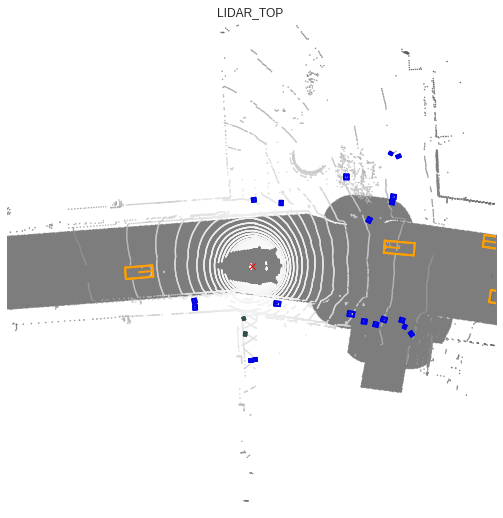

In [15]:
nuscenes.render_sample_data(sample['data']['LIDAR_TOP'])

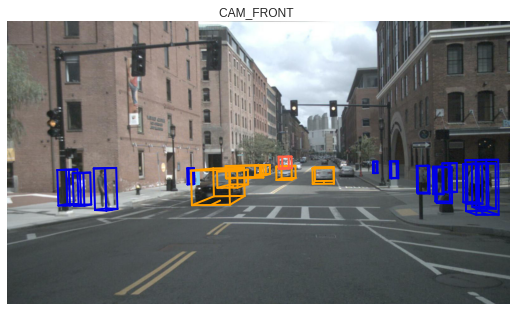

In [17]:
nuscenes.render_sample_data(sample['data']['CAM_FRONT'])

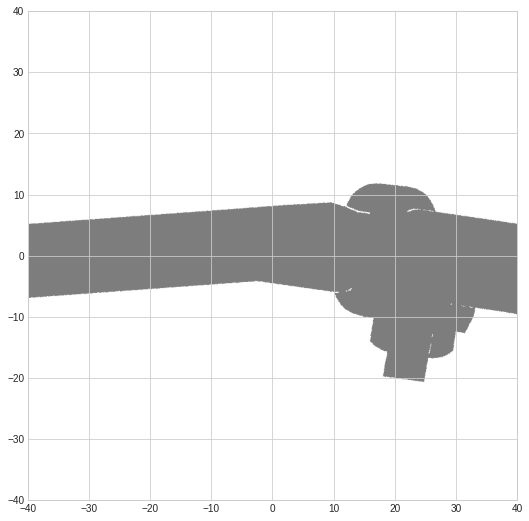

In [22]:
_, ax = plt.subplots(1, 1, figsize=(9, 9))
NuScenesExplorer(nuscenes).render_ego_centric_map(sample['data']['CAM_FRONT'],ax=ax)

  0%|          | 0/4 [00:00<?, ?it/s]

Adding ego poses to map...


100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Creating plot...


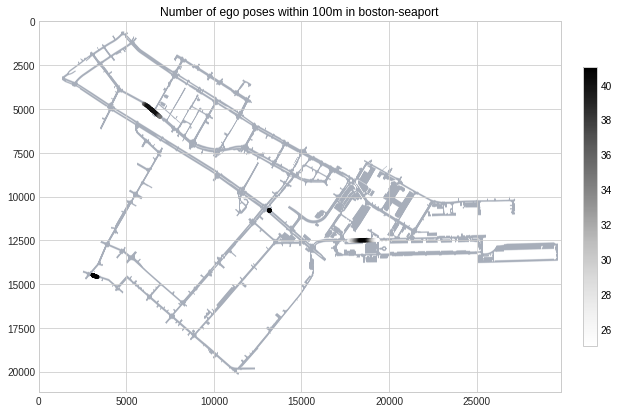

In [7]:
nuscenes.render_egoposes_on_map(log_location=location)